In [ ]:
"""
Построить модель для предсказания дождя на завтрашний день.
Подробное описание полей представлено на сайте: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
Запись консультации доступна по ссылке: https://disk.yandex.ru/i/d0V0TQqmjPNAXA
"""

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, RocCurveDisplay,
                             classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv("weatherAUS.csv")


In [11]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,-1.0,NaN,270.0,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,1.0,1.0
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,-1.0,NaN,270.0,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,1.0,1.0
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,-1.0,NaN,202.5,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,1.0,1.0
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,-1.0,NaN,112.5,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,1.0,1.0
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,-1.0,NaN,112.5,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64186,2017-06-21,Sale,1.8,14.1,0.0,NaN,NaN,-1.0,NaN,270.0,...,87.0,76.0,1028.3,1027.8,8.0,NaN,11.3,12.7,0.0,0.0
64187,2017-06-22,Sale,8.2,13.9,0.0,NaN,NaN,-1.0,NaN,270.0,...,90.0,54.0,1028.4,1024.9,NaN,7.0,9.0,13.5,0.0,0.0
64188,2017-06-23,Sale,2.0,16.3,0.0,NaN,NaN,-1.0,NaN,337.5,...,94.0,44.0,1018.5,1012.2,NaN,3.0,6.0,15.4,0.0,1.0
64189,2017-06-24,Sale,6.0,12.8,1.4,NaN,NaN,-1.0,NaN,337.5,...,92.0,59.0,1017.9,1016.4,NaN,1.0,7.9,11.5,1.0,0.0


In [8]:
# Оставляем только юговосток австралии
# Фильтрация данных
df = df[df['Location'].isin(['Sale', 'Sydney'])].copy()

# Маппинг направлений ветра
wind_mapping = {
    'E': 180, 'ENE': 157.5, 'ESE': 202.5, 'N': 90, 'NE': 135,
    'NNE': 112.5, 'NNW': 67.5, 'NW': 45, 'S': 270, 'SE': 225,
    'SSE': 247.5, 'SSW': 295.5, 'SW': 315, 'W': 270, 'WNW': 22.5, 'WSW': 337.5
}

for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[col] = df[col].map(wind_mapping).fillna(-1)

# Преобразование целевой переменной
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

# Удаление пропусков в целевом признаке
df = df.dropna(subset=['RainTomorrow'])


# Выбор признаков и целевой переменной
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
            'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
            'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
            'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

In [9]:
X = df[features]
y = df['RainTomorrow']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание пайплайна
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Кросс-валидация и предсказания
cv = StratifiedKFold(n_splits=5)
y_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Оптимальный порог по F1-мере
thresholds = np.linspace(0, 1, 100)
f1_scores = [classification_report(y_train, y_proba >= t, output_dict=True)['macro avg']['f1-score'] for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

# Финальное обучение
pipeline.fit(X_train, y_train)
y_pred = (pipeline.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

/Users/silach53/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/silach53/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/silach53/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       966
         1.0       0.67      0.57      0.62       302

    accuracy                           0.83      1268
   macro avg       0.77      0.74      0.75      1268
weighted avg       0.82      0.83      0.83      1268


ROC-AUC Score: 0.8469

Confusion Matrix:
[[882  84]
 [130 172]]


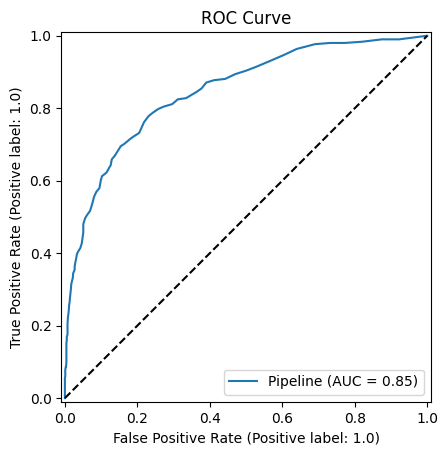


Feature Importances:
          Feature  Importance
4        Sunshine    0.131787
9     Humidity3pm    0.128213
13       Cloud3pm    0.060723
11    Pressure3pm    0.060336
10    Pressure9am    0.058609
2        Rainfall    0.051515
0         MinTemp    0.047048
15        Temp3pm    0.046101
5   WindGustSpeed    0.045686
8     Humidity9am    0.045446
14        Temp9am    0.043606
1         MaxTemp    0.042702
3     Evaporation    0.036289
7    WindSpeed3pm    0.035017
12       Cloud9am    0.034412
6    WindSpeed9am    0.030827
19     WindDir3pm    0.028905
17    WindGustDir    0.028356
18     WindDir9am    0.026241
16      RainToday    0.018182


In [10]:
# Оценка качества
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.4f}")

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-кривая
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Важность признаков
importances = pipeline.named_steps['clf'].feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print("\nFeature Importances:")
print(feature_importance.sort_values('Importance', ascending=False))
